# Interpretable Machine Learning

In this notebook, we will train intepretable machine learning models and 
visualise the decision rules that it learns.

In [1]:
import pandas as pd
import sys
import os
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn import tree
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from forseti.bayesnet import interpretableNaiveBayes, latentLabelClassifier
from forseti.tree import interpretableTree
from forseti.fairness import fairness_report

sns.set_style('darkgrid')

## Decision Tree: Adult Dataset

In [2]:
df = pd.read_csv('data/adult.csv')
label = 'income'
sensitives = ['gender', 'race']
test_size = 0.33

for col in df.select_dtypes('object').columns:
    df[col] = df[col].astype('category')

df[label] = df[label].cat.codes

X = df.drop(label, axis=1)
y = df[label]

categorical_features = X.select_dtypes('category').columns
Xcat = pd.get_dummies(X.select_dtypes('category'), drop_first=True)
X = X.drop(categorical_features, axis=1)
X = X.join(Xcat)

(
    X_train,
    X_test1,
    y_train,
    y_test1
 ) = train_test_split(X, y, test_size=test_size)

Train the model on the training data.

In [3]:
clf1 = DT(
    criterion = 'entropy',
    splitter = 'best',
    max_depth = 4
)

clf1.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [4]:
print(
    tree.export_text(
        clf1,
        feature_names=list(X_train.columns)
    )
)

|--- marital-status_Married-civ-spouse <= 0.50
|   |--- capital-gain <= 7055.50
|   |   |--- age <= 27.50
|   |   |   |--- capital-gain <= -2218.00
|   |   |   |   |--- class: 1
|   |   |   |--- capital-gain >  -2218.00
|   |   |   |   |--- class: 0
|   |   |--- age >  27.50
|   |   |   |--- hours-per-week <= 42.50
|   |   |   |   |--- class: 0
|   |   |   |--- hours-per-week >  42.50
|   |   |   |   |--- class: 0
|   |--- capital-gain >  7055.50
|   |   |--- capital-gain <= 8296.00
|   |   |   |--- capital-gain <= 7436.50
|   |   |   |   |--- class: 1
|   |   |   |--- capital-gain >  7436.50
|   |   |   |   |--- class: 0
|   |   |--- capital-gain >  8296.00
|   |   |   |--- age <= 20.00
|   |   |   |   |--- class: 0
|   |   |   |--- age >  20.00
|   |   |   |   |--- class: 1
|--- marital-status_Married-civ-spouse >  0.50
|   |--- capital-gain <= 5095.50
|   |   |--- capital-gain <= -1846.00
|   |   |   |--- capital-gain <= -1989.50
|   |   |   |   |--- class: 0
|   |   |   |--- capita

Plot decision tree

In [5]:
ranked = np.argsort(clf1.feature_importances_)[::-1]
names = X.columns[ranked]
values = clf1.feature_importances_[ranked]

importance = pd.DataFrame(
    {
        'Attribute': names,
        'Importance': values
    }
)

importance = importance.loc[~(importance['Importance']==0.0)]
print(importance.to_latex())

\begin{tabular}{llr}
\toprule
{} &                          Attribute &  Importance \\
\midrule
0 &  marital-status\_Married-civ-spouse &    0.519503 \\
1 &                       capital-gain &    0.362983 \\
2 &                                age &    0.047529 \\
3 &                education\_Bachelors &    0.042278 \\
4 &                     hours-per-week &    0.026495 \\
5 &                education\_Preschool &    0.001211 \\
\bottomrule
\end{tabular}



## Decision Tree: Compas Dataset

In [6]:
df = pd.read_csv('data/compas-two-yrs-recidivism.csv')
label = 'two_year_recid'

features = [
    'sex',
    'age',
    'race',
    'priors_count',
    'juv_fel_count',
    'juv_misd_count',
    'juv_other_count',
    'c_charge_degree',
    'two_year_recid'
]

df = df[features]
sensitives = ['sex', 'race']
test_size = 0.33

for col in df.select_dtypes('object').columns:
    df[col] = df[col].astype('category')

X = df.drop(label, axis=1)
y = df[label]

categorical_features = X.select_dtypes('category').columns
Xcat = pd.get_dummies(X.select_dtypes('category'), drop_first=True)
X = X.drop(categorical_features, axis=1)
X = X.join(Xcat)

(
    X_train,
    X_test2,
    y_train,
    y_test2
 ) = train_test_split(X, y, test_size=test_size)

In [7]:
clf2 = DT(
    criterion = 'entropy',
    splitter = 'best',
    max_depth = 5
)

clf2.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [8]:
print(
    tree.export_text(
        clf2,
        feature_names=list(X_train.columns)
    )
)

|--- priors_count <= 2.50
|   |--- age <= 23.50
|   |   |--- age <= 20.50
|   |   |   |--- priors_count <= 0.50
|   |   |   |   |--- age <= 19.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- age >  19.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- priors_count >  0.50
|   |   |   |   |--- sex_Male <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- sex_Male >  0.50
|   |   |   |   |   |--- class: 1
|   |   |--- age >  20.50
|   |   |   |--- priors_count <= 1.50
|   |   |   |   |--- sex_Male <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- sex_Male >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- priors_count >  1.50
|   |   |   |   |--- race_Other <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- race_Other >  0.50
|   |   |   |   |   |--- class: 0
|   |--- age >  23.50
|   |   |--- age <= 34.50
|   |   |   |--- priors_count <= 0.50
|   |   |   |   |--- age <= 33.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- a

In [9]:
ranked = np.argsort(clf2.feature_importances_)[::-1]
names = X.columns[ranked]
values = clf2.feature_importances_[ranked]

importance = pd.DataFrame(
    {
        'Attribute': names,
        'Importance': values
    }
)

importance = importance.loc[~(importance['Importance']==0.0)]
print(importance.to_latex())

\begin{tabular}{llr}
\toprule
{} &        Attribute &  Importance \\
\midrule
0 &     priors\_count &    0.524204 \\
1 &              age &    0.405920 \\
2 &  juv\_other\_count &    0.023721 \\
3 &         sex\_Male &    0.022754 \\
4 &       race\_Other &    0.018927 \\
5 &   juv\_misd\_count &    0.004474 \\
\bottomrule
\end{tabular}



## Decision Tree: Synthetic Datasets

In [10]:
df = pd.read_csv('data/synthethic_informative.csv', index_col=0)
label = 'Success'

sensitives = ['Sex', 'Race']
test_size = 0.33

for col in df.select_dtypes('object').columns:
    df[col] = df[col].astype('category')

X = df.drop(label, axis=1)
y = df[label]

categorical_features = X.select_dtypes('category').columns
Xcat = pd.get_dummies(X.select_dtypes('category'))
X = X.drop(categorical_features, axis=1)
X = X.join(Xcat)

In [11]:
(
    X_train,
    X_test3,
    y_train,
    y_test3
 ) = train_test_split(X, y, test_size=test_size)

In [12]:
clf3 = DT(
    criterion = 'entropy',
    splitter = 'best',
    max_depth = 4
)

clf3.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [13]:
ranked = np.argsort(clf3.feature_importances_)[::-1]
names = X.columns[ranked]
values = clf3.feature_importances_[ranked]

importance = pd.DataFrame(
    {
        'Attribute': names,
        'Importance': values
    }
)

importance = importance.loc[~(importance['Importance']==0.0)]
print(importance.to_latex())

\begin{tabular}{llr}
\toprule
{} &   Attribute &  Importance \\
\midrule
0 &   Feature 4 &    0.431817 \\
1 &   Feature 1 &    0.173041 \\
2 &   Feature 2 &    0.168558 \\
3 &   Feature 3 &    0.119848 \\
4 &  Race\_White &    0.106736 \\
\bottomrule
\end{tabular}



In [14]:
plt.figure()
a=plot_roc_curve(clf1, X_test1, y_test1, name='Adult');
b=plot_roc_curve(clf2, X_test2, y_test2, ax=a.ax_, name='Compas');
c=plot_roc_curve(clf3, X_test3, y_test3, ax=b.ax_, name='Synthetic');
plt.title('ROC Curve Decision Tree')
plt.savefig(
    'figures/dt-roc.png',
    dpi=300
)
plt.close()

/home/bcwein/anaconda3/envs/forseti/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/bcwein/anaconda3/envs/forseti/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/bcwein/anaconda3/envs/forseti/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Functio

<Figure size 432x288 with 0 Axes>

## Naive Bayes: Adult Dataset

In [15]:
df = pd.read_csv('data/adult.csv')
label = 'income'

model = interpretableNaiveBayes()
model.train(
    label,
    df,
    'NBSens'
)

df1 = model.KLDWeights()
permw1 = model.PermutationImportance(1, 'NBSens');

  0%|          | 0/1828 [00:00<?, ?it/s]

  0%|          | 0/1929 [00:00<?, ?it/s]

  0%|          | 0/1998 [00:00<?, ?it/s]

  0%|          | 0/2083 [00:00<?, ?it/s]

  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/2284 [00:00<?, ?it/s]

  0%|          | 0/2325 [00:00<?, ?it/s]

  0%|          | 0/2320 [00:00<?, ?it/s]

  0%|          | 0/2318 [00:00<?, ?it/s]

  0%|          | 0/2315 [00:00<?, ?it/s]

  0%|          | 0/2304 [00:00<?, ?it/s]

### Naive Bayes Without Sensitive

In [16]:
df = pd.read_csv('data/adult.csv')
sensitives = ['gender', 'race']
label = 'income'
df = df.drop(sensitives, axis=1)

model = interpretableNaiveBayes()
model.train(
    label,
    df,
    'NB'
)

df2 = model.KLDWeights()
permw2 = model.PermutationImportance(1, 'NB');

  0%|          | 0/1668 [00:00<?, ?it/s]

  0%|          | 0/1792 [00:00<?, ?it/s]

  0%|          | 0/1871 [00:00<?, ?it/s]

  0%|          | 0/1944 [00:00<?, ?it/s]

  0%|          | 0/2153 [00:00<?, ?it/s]

  0%|          | 0/2185 [00:00<?, ?it/s]

  0%|          | 0/2200 [00:00<?, ?it/s]

  0%|          | 0/2202 [00:00<?, ?it/s]

  0%|          | 0/2184 [00:00<?, ?it/s]

### Merge Dataframes

In [17]:
modeldiff = df1.append(df2, ignore_index=True)
permw = permw1.append(permw2, ignore_index=True)

### Plot model difference

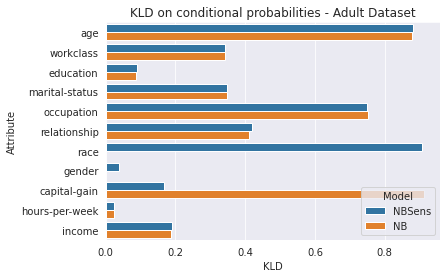

In [18]:
sns.set_style('darkgrid')

p = sns.barplot(
    x='KLD',
    y='Attribute',
    hue='Model',
    data=modeldiff
)

p.set_title('KLD on conditional probabilities - Adult Dataset')
plt.savefig('figures/KLDimportance-adult.png', dpi=300)

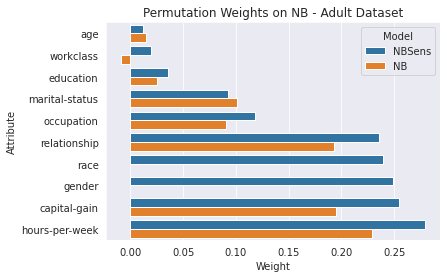

In [19]:
sns.set_style('darkgrid')

p = sns.barplot(
    x='Weight',
    y='Attribute',
    hue='Model',
    data=permw
)

p.set_title('Permutation Weights on NB - Adult Dataset')
plt.savefig('figures/permimportance-adult.png', dpi=300)

## Naive Bayes: Compas Dataset

In [20]:
df = pd.read_csv('data/compas-two-yrs-recidivism.csv')

features = [
    'race',
    'sex',
    'priors_count',
    'juv_fel_count',
    'juv_misd_count',
    'juv_other_count',
    'c_charge_degree',
    'two_year_recid'
]

df = df[features]
label = 'two_year_recid'

model = interpretableNaiveBayes()

model.train(
    label,
    df,
    'NBSens'
)

df1 = model.KLDWeights()
permw1 = model.PermutationImportance(1, 'NBSens');

  0%|          | 0/51 [00:00<?, ?it/s]

/home/bcwein/anaconda3/envs/forseti/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:537: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  UserWarning,
/home/bcwein/anaconda3/envs/forseti/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:537: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  UserWarning,


  0%|          | 0/56 [00:00<?, ?it/s]

/home/bcwein/anaconda3/envs/forseti/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:537: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  UserWarning,
/home/bcwein/anaconda3/envs/forseti/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:537: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  UserWarning,


  0%|          | 0/59 [00:00<?, ?it/s]

/home/bcwein/anaconda3/envs/forseti/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:537: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  UserWarning,
/home/bcwein/anaconda3/envs/forseti/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:537: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  UserWarning,


  0%|          | 0/56 [00:00<?, ?it/s]

/home/bcwein/anaconda3/envs/forseti/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:537: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  UserWarning,
/home/bcwein/anaconda3/envs/forseti/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:537: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  UserWarning,


  0%|          | 0/55 [00:00<?, ?it/s]

/home/bcwein/anaconda3/envs/forseti/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:537: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  UserWarning,


  0%|          | 0/57 [00:00<?, ?it/s]

/home/bcwein/anaconda3/envs/forseti/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:537: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  UserWarning,


  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

### Naive Bayes Without Sensitive

In [21]:
df = pd.read_csv('data/compas-two-yrs-recidivism.csv')

features = [
    'priors_count',
    'juv_fel_count',
    'juv_misd_count',
    'juv_other_count',
    'c_charge_degree',
    'two_year_recid'
]

df = df[features]
label = 'two_year_recid'

model = interpretableNaiveBayes()
model.train(
    label,
    df,
    'NB'
)

df2 = model.KLDWeights()
permw2 = model.PermutationImportance(1, 'NB');

  0%|          | 0/33 [00:00<?, ?it/s]

/home/bcwein/anaconda3/envs/forseti/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:537: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  UserWarning,
/home/bcwein/anaconda3/envs/forseti/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:537: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  UserWarning,
/home/bcwein/anaconda3/envs/forseti/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:537: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  UserWarning,


  0%|          | 0/30 [00:00<?, ?it/s]

/home/bcwein/anaconda3/envs/forseti/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:537: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  UserWarning,


  0%|          | 0/31 [00:00<?, ?it/s]

/home/bcwein/anaconda3/envs/forseti/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:537: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  UserWarning,


  0%|          | 0/30 [00:00<?, ?it/s]

/home/bcwein/anaconda3/envs/forseti/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:537: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  UserWarning,


  0%|          | 0/30 [00:00<?, ?it/s]

/home/bcwein/anaconda3/envs/forseti/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:537: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  UserWarning,
/home/bcwein/anaconda3/envs/forseti/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:537: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  UserWarning,


  0%|          | 0/31 [00:00<?, ?it/s]

/home/bcwein/anaconda3/envs/forseti/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:537: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  UserWarning,


### Merge Dataframes

In [22]:
modeldiff = df1.append(df2, ignore_index=True)
permw = permw1.append(permw2, ignore_index=True)

### Plot model difference

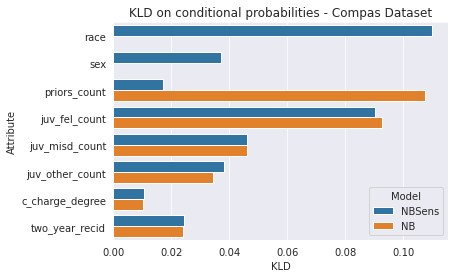

In [23]:
sns.set_style('darkgrid')

p = sns.barplot(
    x='KLD',
    y='Attribute',
    hue='Model',
    data=modeldiff
)

p.set_title('KLD on conditional probabilities - Compas Dataset')
plt.savefig('figures/KLDimportance-compas.png', dpi=300)

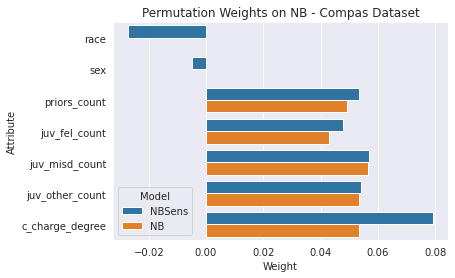

In [24]:
sns.set_style('darkgrid')

p = sns.barplot(
    x='Weight',
    y='Attribute',
    hue='Model',
    data=permw
)

p.set_title('Permutation Weights on NB - Compas Dataset')
plt.savefig('figures/permimportance-compas.png', dpi=300)

## Naive Bayes: Synthetic

In [25]:
df = pd.read_csv('data/synthethic_informative.csv', index_col=0)
label = 'Success'

model = interpretableNaiveBayes()

model.train(
    label,
    df,
    'NBSens'
)

df1 = model.KLDWeights()
permw1 = model.PermutationImportance(1, 'NBSens');

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

### Without sensitive

In [26]:
sensitives=['Gender', 'Race']
df = df.drop(sensitives, axis=1)

model = interpretableNaiveBayes()
model.train(
    label,
    df,
    'NB'
)

df2 = model.KLDWeights()
permw2 = model.PermutationImportance(1, 'NB');

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

### Merge dataframes

In [27]:
modeldiff = df1.append(df2, ignore_index=True)
permw = permw1.append(permw2, ignore_index=True)

### Plot model difference

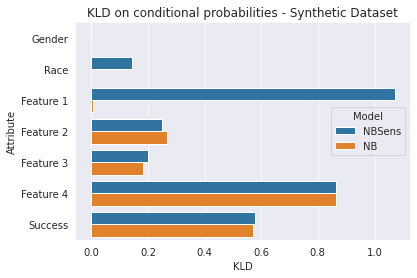

In [28]:
sns.set_style('darkgrid')

p = sns.barplot(
    x='KLD',
    y='Attribute',
    hue='Model',
    data=modeldiff
)

p.set_title('KLD on conditional probabilities - Synthetic Dataset')
plt.savefig('figures/KLDimportance-synthetic.png', dpi=300)

### 

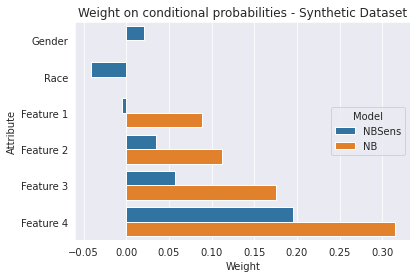

In [29]:
sns.set_style('darkgrid')

p = sns.barplot(
    x='Weight',
    y='Attribute',
    hue='Model',
    data=permw
)

p.set_title('Weight on conditional probabilities - Synthetic Dataset')
plt.savefig('figures/permimportance-synthetic.png', dpi=300)

# Fair Random Forest

## Adult Dataset with $\theta$ = 0.3

In [30]:
df = pd.read_csv('data/adult.csv')
sensitives = ['gender', 'race']
label = 'income'

clf = interpretableTree()

clf.train(
    df,
    sensitives,
    label,
    orth=0.3
)

frfcw1 = clf.PermutationImportance(1, 'FRFC03')

## Adult Dataset with $\theta$ = 0.5

In [31]:
df = pd.read_csv('data/adult.csv')
sensitives = ['gender', 'race']
label = 'income'

clf = interpretableTree()

clf.train(
    df,
    sensitives,
    label,
    orth=0.5
)

frfcw2 = clf.PermutationImportance(1, 'FRFC05')

## Adult Dataset with $\theta$ = 0.7

In [32]:
df = pd.read_csv('data/adult.csv')
sensitives = ['gender', 'race']
label = 'income'

clf = interpretableTree()

clf.train(
    df,
    sensitives,
    label,
    orth=0.7
)

frfcw3 = clf.PermutationImportance(1, 'FRFC07')

## Join Dataframes

In [33]:
frfcw = frfcw1.append(
    frfcw2.append(
        frfcw3, ignore_index=True
    ),
    ignore_index=True
)

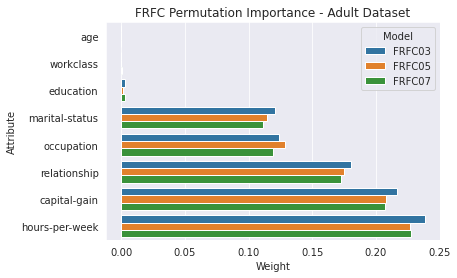

In [34]:
sns.set_style('darkgrid')

p = sns.barplot(
    x='Weight',
    y='Attribute',
    hue='Model',
    data=frfcw
)

p.set_title('FRFC Permutation Importance - Adult Dataset')
plt.savefig('figures/frfc-permimportance-adult.png', dpi=300)

# Latent Fair Label Bayesian Network

In [ ]:
df = pd.read_csv('data/adult.csv')
sensitives = ['gender', 'race']
label = 'income'

clf = latentLabelClassifier(
    df,
    sensitives,
    label,
    atol=0.01
)

clf.load('trained-models/fair_model.sav')

fairbnw = clf.PermutationImportance(1, name='fairBN')

  0%|          | 0/8268 [00:00<?, ?it/s]

/home/bcwein/anaconda3/envs/forseti/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:472: RuntimeWarning: invalid value encountered in true_divide
  phi.values = phi.values / phi.values.sum()
/home/bcwein/anaconda3/envs/forseti/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:472: RuntimeWarning: invalid value encountered in true_divide
  phi.values = phi.values / phi.values.sum()
/home/bcwein/anaconda3/envs/forseti/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:472: RuntimeWarning: invalid value encountered in true_divide
  phi.values = phi.values / phi.values.sum()
/home/bcwein/anaconda3/envs/forseti/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:472: RuntimeWarning: invalid value encountered in true_divide
  phi.values = phi.values / phi.values.sum()
/home/bcwein/anaconda3/envs/forseti/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:472: RuntimeWarning: invalid value encountered 

  0%|          | 0/8971 [00:00<?, ?it/s]

/home/bcwein/anaconda3/envs/forseti/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:472: RuntimeWarning: invalid value encountered in true_divide
  phi.values = phi.values / phi.values.sum()
/home/bcwein/anaconda3/envs/forseti/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:472: RuntimeWarning: invalid value encountered in true_divide
  phi.values = phi.values / phi.values.sum()
/home/bcwein/anaconda3/envs/forseti/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:472: RuntimeWarning: invalid value encountered in true_divide
  phi.values = phi.values / phi.values.sum()
/home/bcwein/anaconda3/envs/forseti/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:472: RuntimeWarning: invalid value encountered in true_divide
  phi.values = phi.values / phi.values.sum()
/home/bcwein/anaconda3/envs/forseti/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:472: RuntimeWarning: invalid value encountered 

  0%|          | 0/9879 [00:00<?, ?it/s]

/home/bcwein/anaconda3/envs/forseti/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:472: RuntimeWarning: invalid value encountered in true_divide
  phi.values = phi.values / phi.values.sum()
/home/bcwein/anaconda3/envs/forseti/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:472: RuntimeWarning: invalid value encountered in true_divide
  phi.values = phi.values / phi.values.sum()
/home/bcwein/anaconda3/envs/forseti/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:472: RuntimeWarning: invalid value encountered in true_divide
  phi.values = phi.values / phi.values.sum()
/home/bcwein/anaconda3/envs/forseti/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:472: RuntimeWarning: invalid value encountered in true_divide
  phi.values = phi.values / phi.values.sum()
/home/bcwein/anaconda3/envs/forseti/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:472: RuntimeWarning: invalid value encountered 

  0%|          | 0/10495 [00:00<?, ?it/s]

  0%|          | 0/12158 [00:00<?, ?it/s]

  0%|          | 0/12528 [00:00<?, ?it/s]

  0%|          | 0/13176 [00:00<?, ?it/s]

  0%|          | 0/13133 [00:00<?, ?it/s]

  0%|          | 0/13129 [00:00<?, ?it/s]

  0%|          | 0/13130 [00:00<?, ?it/s]

  0%|          | 0/13084 [00:00<?, ?it/s]

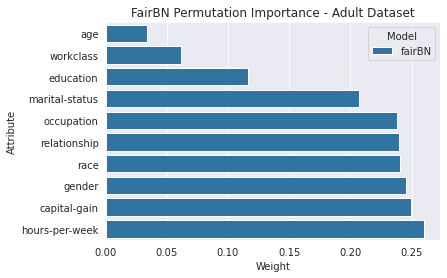

In [ ]:
sns.set_style('darkgrid')

p = sns.barplot(
    x='Weight',
    y='Attribute',
    hue='Model',
    data=fairbnw
)

p.set_title('FairBN Permutation Importance - Adult Dataset')
plt.savefig('figures/fairbn-permimportance-adult.png', dpi=300)